In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

import fnmatch
import os
import pandas as pd
import geopandas as gpd

from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.helpers import write_geotiff
import xarray as xr

#get the DEA version of the plotting functions
import sys
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/dea-notebooks/10_Scripts'))
import DEAPlotting
import DEADataHandling


import datacube
dc = datacube.Datacube(app='load_sentinel_example')

In [39]:
'''
query = {
        'lat': (-35.27, -35.33),
        'lon': (149.07, 149.15),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time': ('2017-01-01', '2017-02-01')
        }

Canberra = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)
'''

"\nquery = {\n        'lat': (-35.27, -35.33),\n        'lon': (149.07, 149.15),\n        'output_crs': 'EPSG:3577',\n        'resolution': (-20, 20),\n        'time': ('2017-01-01', '2017-02-01')\n        }\n\nCanberra = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)\n"

In [17]:
#x, y = (1300000.0, 1350000.0), (-4750000.0, -4800000.0)
x, y = (1310000.00, 1330000.00), (-4720000.00, -4740000.00)
#product = 'nbart' #can be 'nbar', 'nbart' or 'fc'. Defaults to 'nbart'
#sensors = ['ls7', 'ls8'] #take or remove as needed
time = ('2017-10-01', '2017-12-31')
bands = ['nbart_blue', 'nbart_green', 'nbart_red']
#bands = ['nbart_red', 'nbart_green',  'nbart_blue']
resolution = (-10,10)

query = {
        'x': x,
        'y': y,
        #'lat': (-35.27, -35.33),
        #'lon': (149.07, 149.15),
        'crs': 'EPSG:3577',
        'output_crs': 'EPSG:3577',
        'resolution': resolution, #(-20, 20),
        'time': time #('2017-01-01', '2017-02-01')
        }

#canberra_cm = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

canberra_cm = DEADataHandling.load_clearsentinel2(dc=dc, query=query,
                                                  masked_prop=0,
                                                  bands_of_interest = bands,
                                                  #mask_invalid_data = False,
                                                  mask_pixel_quality=True) 


Loading s2a pixel quality
    Loading 9 filtered s2a timesteps
Loading s2b pixel quality
    Loading 8 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [18]:
# function to return months of interest
def is_cm(month):
    return (month >= 11) | (month <= 4)

In [19]:
# extract just the months of interest
sent_cm = canberra_cm.sel(time=is_cm(canberra_cm['time.month']))

In [20]:
canberra_cm['time.month']

<xarray.DataArray 'month' (time: 17)>
array([10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12])
Coordinates:
  * time     (time) datetime64[ns] 2017-10-02T00:02:41.026000 ... 2017-12-26T00:02:09.027000

In [21]:
canberra_cm

<xarray.Dataset>
Dimensions:      (time: 17, x: 2000, y: 2000)
Coordinates:
  * y            (y) float64 -4.72e+06 -4.72e+06 ... -4.74e+06 -4.74e+06
  * x            (x) float64 1.31e+06 1.31e+06 1.31e+06 ... 1.33e+06 1.33e+06
  * time         (time) datetime64[ns] 2017-10-02T00:02:41.026000 ... 2017-12-26T00:02:09.027000
Data variables:
    nbart_blue   (time, y, x) float64 nan nan nan nan ... 401.0 349.0 347.0
    nbart_green  (time, y, x) float64 nan nan nan nan ... 435.0 449.0 367.0
    nbart_red    (time, y, x) float64 nan nan nan nan ... 406.0 404.0 295.0
    data_perc    (time, y, x) float64 nan nan nan nan ... 0.8327 0.8327 0.8327
Attributes:
    crs:      EPSG:3577

In [22]:
sent_cm

<xarray.Dataset>
Dimensions:      (time: 11, x: 2000, y: 2000)
Coordinates:
  * y            (y) float64 -4.72e+06 -4.72e+06 ... -4.74e+06 -4.74e+06
  * x            (x) float64 1.31e+06 1.31e+06 1.31e+06 ... 1.33e+06 1.33e+06
  * time         (time) datetime64[ns] 2017-11-01T00:08:41.026000 ... 2017-12-26T00:02:09.027000
Data variables:
    nbart_blue   (time, y, x) float64 nan nan nan nan ... 401.0 349.0 347.0
    nbart_green  (time, y, x) float64 nan nan nan nan ... 435.0 449.0 367.0
    nbart_red    (time, y, x) float64 nan nan nan nan ... 406.0 404.0 295.0
    data_perc    (time, y, x) float64 nan nan nan nan ... 0.8327 0.8327 0.8327
Attributes:
    crs:      EPSG:3577

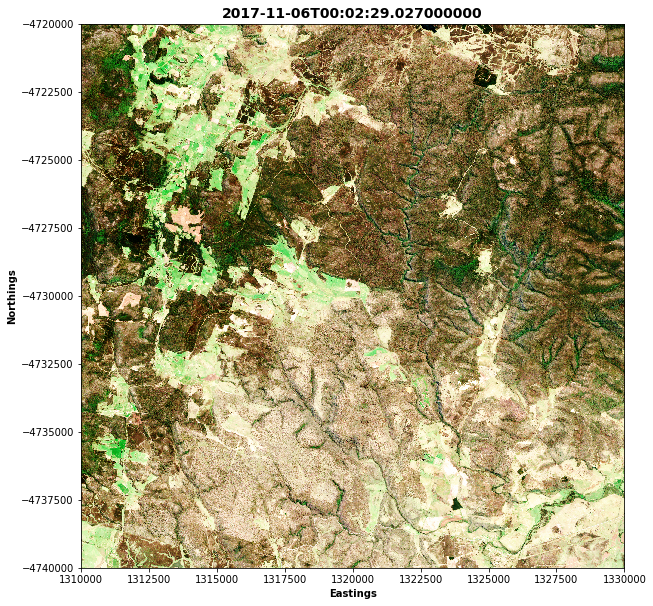

In [24]:
DEAPlotting.three_band_image(sent_cm, bands = ['nbart_red', 'nbart_green', 'nbart_blue'], time = 1, contrast_enhance=True);

In [25]:
sent_cmgm = GeoMedian().compute(sent_cm)

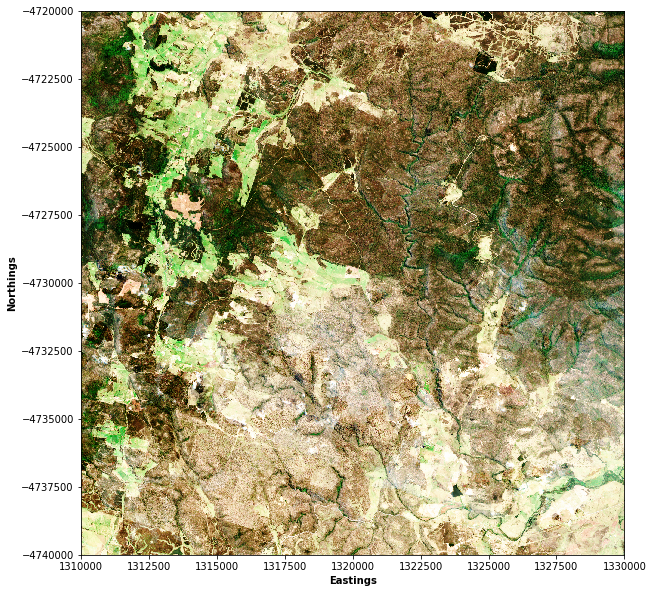

In [26]:
DEAPlotting.three_band_image(sent_cmgm, bands = ['nbart_red', 'nbart_green', 'nbart_blue'], contrast_enhance=True);